<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab03_source_filter/FormantDistribution.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 
# Formant Distribution
### Distributions of steady state Formants
____


The main purpose of this demo notebook is to explore formant statistics based on
the Hillenbrand database (1995).   Hillenbrand wanted to redo the seminal Peterson and Barney experiments from the early 1950's, of which the original speech data was not preserved.
Hillenbrand found significant differences from the P-B data, that might be due to a number of factors:        
    - formant measurements were now based on LPC analysis and not purely human reading from wideband spectrograms   
    - population choice   
    - dialectic evolution   
    - ...   

Since these P-B experiments we know that formants (especially F1 and F2)
carry great discriminative power when it comes to recognizing vowels.
In the very early days of automatic speech recognition formant extraction followed by formant based recognition was considered one of the ways to go.  This is long obsolete by now.
Formants are too ill-defined and as a feature set it is too minimal.   
At the same time formants are robust against all kinds of signal manipulations and are
illustrative for the tremendous redundancy present in speech
(from a recognition point of view) .   

In this notebook we focus on the 'explorative phase' in which we explore the potential of formants for speech recognition.

The goal is to observe both WITHIN and BETWEEN class differences.   Also observe that there are significant side factors entering into this recognition game: gender, age, .. 

In [1]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [13]:
# Importing some core Python libraries for data handling and plotting's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import pyspch.core as Spch
import pyspch.display as Spd
from pyspch.core.hillenbrand import fetch_hillenbrand, select_hillenbrand
#
np.set_printoptions(precision=2)
mpl.rcParams['figure.figsize'] = [8.,7.]
mpl.rcParams['font.size'] = 11

In [9]:
# A small utility function to set axis to semilog (x=linear, y=log) and adjust range and labels
def set_ax(ax,xlim=[200,1200],ylim=[700,3500],semilog=True,
                   yticks=[1000.,1500.,2000.,3000.],
                   yticklabels=['1000','1500','2000','3000']):
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if semilog:
        ax.set_yscale('log')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels);   

## 1. The Hillenbrand Database 
All demonstrations in this notebook are using (parts of) the Hillenbrand '95 database. For detailed information and references: http://homes.esat.kuleuven.be/~spchlab/data/hillenbrand/README.txt

The function *fetch_hillenbrand()* fetches the Hillenbrand database or part of it. By default it returns the most used columns.
Possible subselection criteria for rows are genders="..." and vowels="...". Columns are selected with the columns arguments. 

To get more details on this routine, type help(fetch_hillenbrand)

The fetch_hillenbrand() returns a pandas dataframe.   This is a basic 2-dimensional datastructure.  The rows are data records; these may be labeled by an index; in the example below the index is the file-id.  The columns are labeled data fields.  As called, the routine returns gender, vowel, f0, F1, F2 and F3.  The first 2 are label (class) properties.  The latter 4 are numeric values.
We drop all records with missing data values in the requested fields.

### Hillenbrand vs. Peterson-Barney
The Hillenbrand dataset is mainly a recreation of the famous Peterson-Barney dataset, of which the data was not preserved.  There are also a few notable differences:
- Hillenbrand contains data on 12 instead of 10 vowels.  However the extra vowels ('ey'('ei') and 'ow'('oa') are diphtongs rather than steady state vowels) and not truly suitable for steady state analysis.  We omit those 2 diphtongs in the analysis here.
- The 'mean' values in the Hillenbrand database deviate significantly from what was reported by Peterson and Barney, indicating a linguistic shift, regional speaker differences, or other unexplained causes, ... 

In this notebook we convert the Hillebrand notations to standard ARPABET phone symbols.

In [10]:
hildata = fetch_hillenbrand(symbols='arpa').dropna()
all_vowels = np.unique(hildata['vowel'])
all_genders = np.unique(hildata['gender'])
all_features = ["f0","F1","F2","F3"]
print(all_vowels)
print(all_genders)
print(all_features)
#
hildata

['aa' 'ae' 'ah' 'ao' 'eh' 'er' 'ey' 'ih' 'iy' 'ow' 'uh' 'uw']
['b' 'g' 'm' 'w']
['f0', 'F1', 'F2', 'F3']


,gender,vowel,f0,F1,F2,F3
fid,,,,,,
m01ae,m,ae,174.0,663.0,2012.0,2659.0
m02ae,m,ae,102.0,628.0,1871.0,2477.0
m03ae,m,ae,99.0,605.0,1812.0,2570.0
m04ae,m,ae,124.0,627.0,1910.0,2488.0
m06ae,m,ae,115.0,647.0,1864.0,2561.0
...,...,...,...,...,...,...
g17uw,g,uw,236.0,490.0,2179.0,3131.0
g18uw,g,uw,214.0,435.0,1829.0,3316.0
g19uw,g,uw,243.0,497.0,1334.0,3067.0


In [11]:
# get default color and marker orders for pyspch.display
markers = Spd.markers
colors = Spd.colors
cmap = sns.color_palette(colors)
sns.set_palette(cmap)
#
table_order = ['iy','ih','eh','ae','aa','ao','uh','uw','ah','er','ey','ow']
vowel_order = ['iy','aa','uw','ih','eh','er','ah','ae','ao','uh','ey','ow']
vowel2color = dict(zip(vowel_order,colors))
color2vowel = dict(zip(colors,vowel_order))
vow12 = vowel_order
vow10 = vowel_order[0:10]
vow3 = vowel_order[0:3]
vow6 = vowel_order[0:6]
# selected adult data
data3 = select_hillenbrand(hildata,genders='adults',vowels=vow3)
data6 = select_hillenbrand(hildata,genders='adults',vowels=vow6)
data10 = select_hillenbrand(hildata,genders='adults',vowels=vow10)

## 2. F1-F2 Scatter Plots

Scatter plots are give you an intuitive feeling of how classes differ from one another in "feature space", i.e. for the features that you have selected.  We can only visualize this well for 2 dimensions and to some extent for 3D as well.   
The scatter plots below are shown for 3, 6, respectively 10 classes (the vowel classes used by Peterson & Barney, 1952).
While the 3 classes are perfectly separable in the F1-F2 space, this is only partially true for the 6 classes and not at all anymore for the 10 class data.

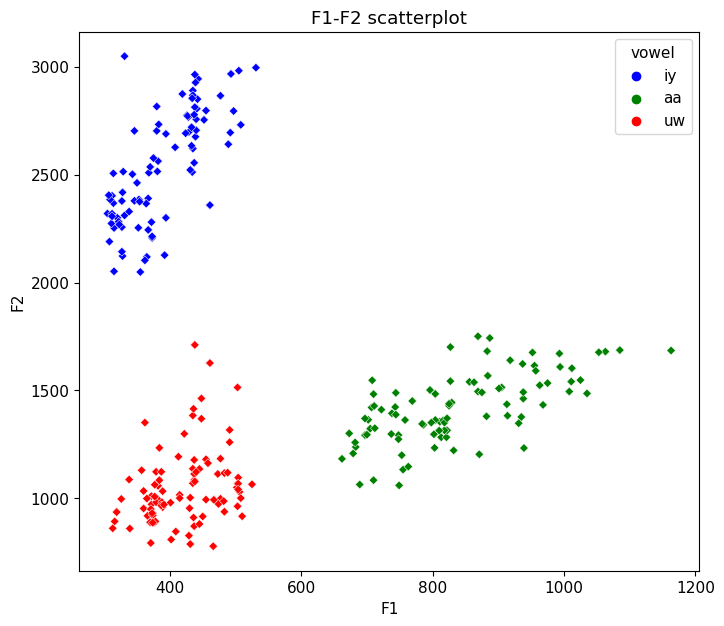

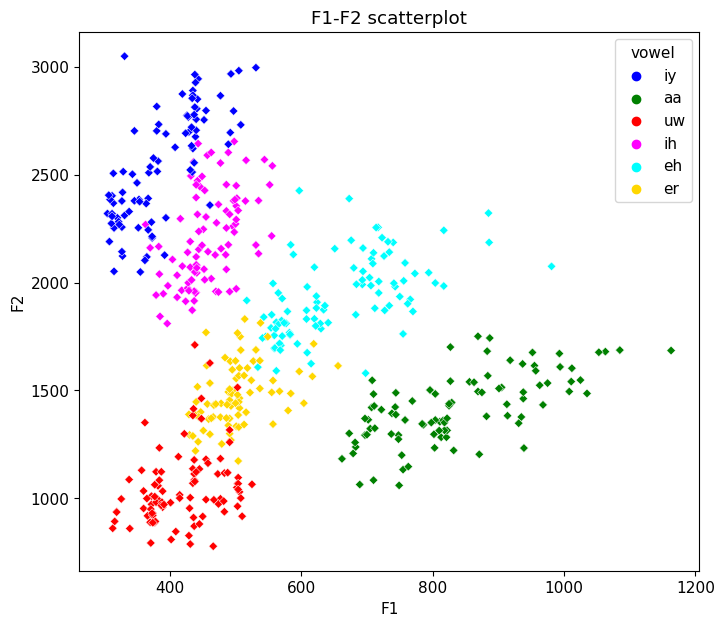

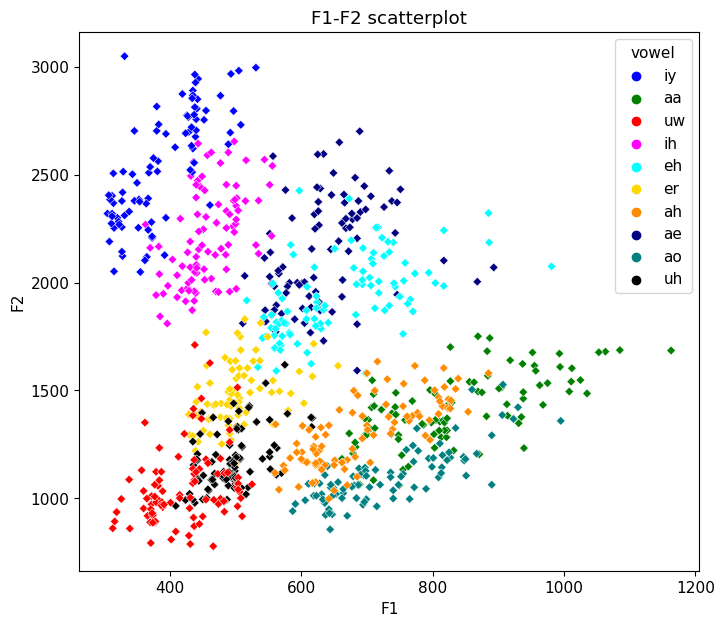

In [14]:
#genders = 'adults'
# select the vowels you want to plot
for (vow,data) in zip([vow3,vow6,vow10],[data3,data6,data10]):
    f,ax = plt.subplots()
    sns.scatterplot(ax=ax,x='F1',y='F2',data=data,hue="vowel",marker='D',s=20,hue_order=vow)
    ax.set_title('F1-F2 scatterplot');
    #uncomment next line for F2 data on log scale
    #set_ax(ax)

#### F1-F2 Scatter plot with labels printed at each data point
The above scatter plots can also be shown in a variant where the datapoints are marked with their own label

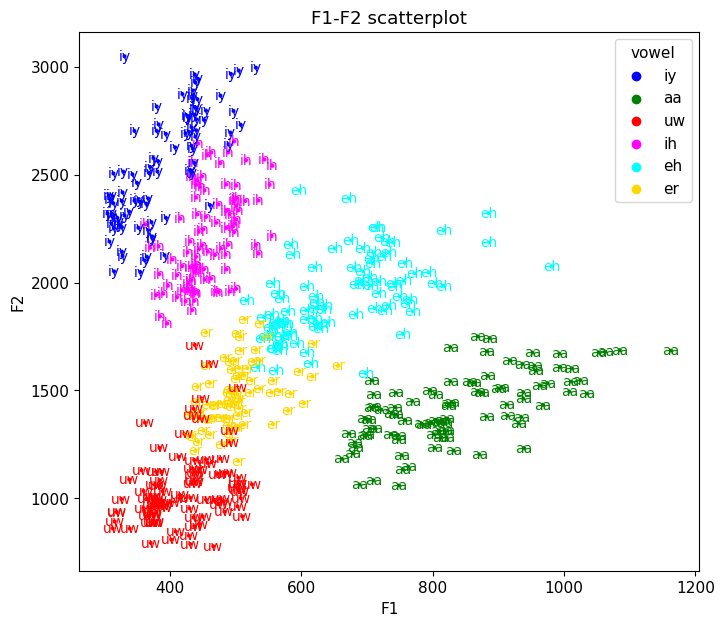

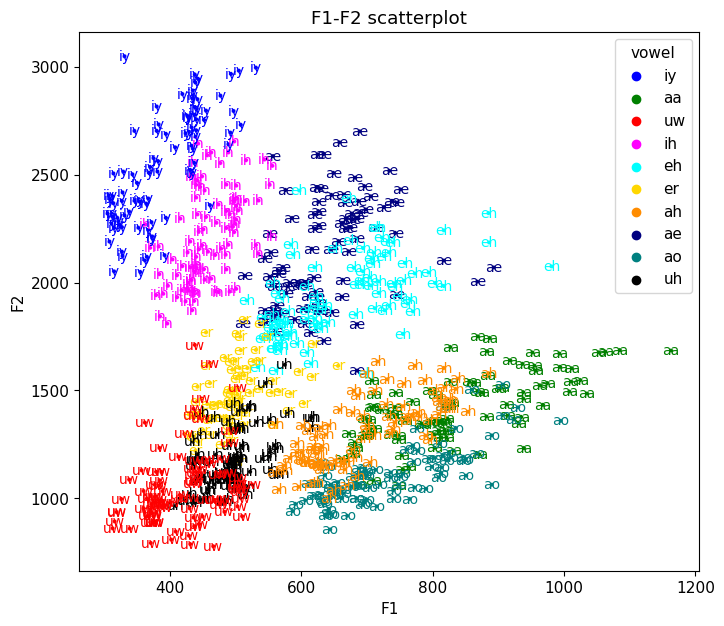

In [15]:
ftr = ['F1','F2']
genders = 'adults'
for data,vowels in zip([data6,data10],[vow6,vow10]):
    f,ax = plt.subplots()
    sns.scatterplot(x=ftr[0],y=ftr[1],data=data,hue="vowel",s=10,hue_order=vowels);
    for i,entry in data.iterrows():
        vow = entry['vowel']
        plt.text(entry[ftr[0]],entry[ftr[1]],vow,ha='center',va='center',fontsize=10,color=vowel2color[vow] )
        ax.set_title('F1-F2 scatterplot');
        #uncomment next 2 lines for F2 data on log scale
        #plt.yscale('log')
        #ax.set_yticks([800.,1000.,1500,2000.,3000.],["800","1000","1500","2000","3000"])

## 3. Overlaying Scatter plots with Confidence Ellipses
Scatter plots are a non parametric data model.   
For pattern recognition purposes we tend to build parametric models that can generalize from the data.
Such models may answer better how intrinsically separable the classes are.
Here we are using simple gaussian fits and in the plots below we draw confidence ellipses .

#### Confidence Ellipses using Diagonal Covariance Matrix
In this case we just measure the standard deviation for each feature

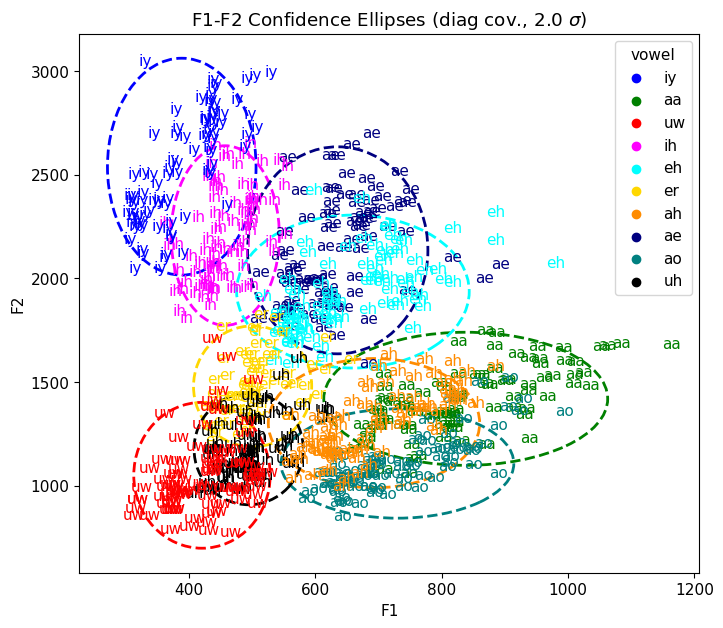

In [21]:
marker_txt = ('a','b')
genders = ['m','w']
(xfeat,yfeat) = ['F1','F2']
vowels = vow10
data = data10
n_std = 2
Diagonal = True

# setup the scatterplot and legend
fig,ax=plt.subplots()
sns.scatterplot(x=xfeat,y=yfeat,data=data,hue='vowel',hue_order=vowels,s=0)
#uncomment next line for F2 data on log scale
#plt.yscale('log')
#ax.set_yticks([800.,1000.,1500,2000.,3000.],["800","1000","1500","2000","3000"])

# plot the datapoints as text
for i,entry in data.iterrows():
    vow = entry['vowel']
    ax.text(entry[xfeat],entry[yfeat],vow,ha='center',va='center',color=vowel2color[vow] )
    
for vow in vowels:
    vowdata = select_hillenbrand(hildata,genders=genders,vowels=[vow])
    Spch.plot_confidence_ellipse(vowdata[xfeat], vowdata[yfeat], ax, n_std=n_std, Diagonal=Diagonal, edgecolor=vowel2color[vow],linewidth=2 ,linestyle='--')
    
#sns.scatterplot(ax=f.axes[0],data=formants,x='F1',y='F2',hue='vowel',style='gender',s=2000)
#ax.legend(loc='upper left', bbox_to_anchor=(.9,1));
if Diagonal:
    ax.set_title("F1-F2 Confidence Ellipses (diag cov., %.1f $\sigma$)" % n_std);
else:
    ax.set_title("F1-F2 Confidence Ellipses (full cov., %.1f$\sigma$)" % n_std);

#### Confidence Ellipses using Full Covariance Matrix
In order to plot these confidence ellipses we both measure standard deviation and correlation between the features

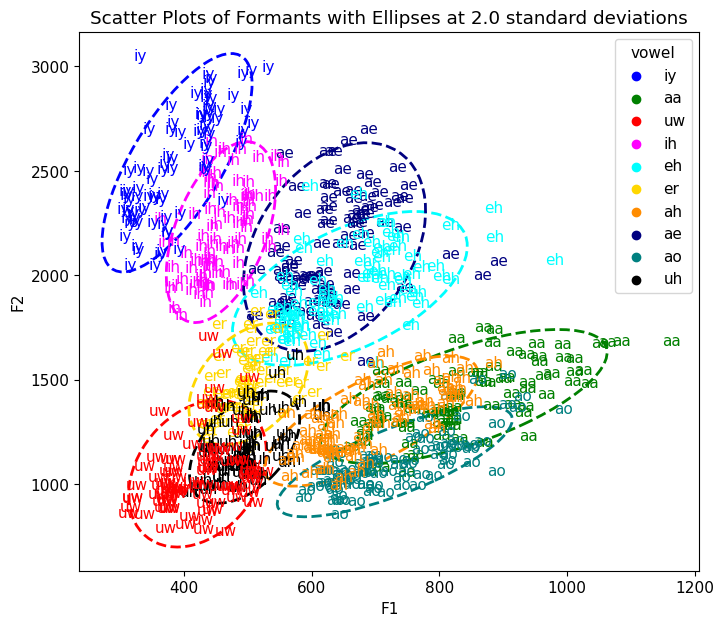

In [23]:
marker_txt = ('a','b')
genders = ['m','w']
(xfeat,yfeat) = ['F1','F2']
vowels = vow10
data = data10
n_std = 2

# setup the scatterplot and legend
fig,ax=plt.subplots()
sns.scatterplot(x=xfeat,y=yfeat,data=data,hue='vowel',hue_order=vowels,s=0)
#uncomment next line for F2 data on log scale
#plt.yscale('log')
#ax.set_yticks([800.,1000.,1500,2000.,3000.],["800","1000","1500","2000","3000"])

# plot the datapoints as text
for i,entry in data.iterrows():
    vow = entry['vowel']
    ax.text(entry[xfeat],entry[yfeat],vow,ha='center',va='center',color=vowel2color[vow] )
    
for vow in vowels:
    vowdata = select_hillenbrand(hildata,genders=genders,vowels=[vow])
    Spch.plot_confidence_ellipse(vowdata[xfeat], vowdata[yfeat], ax, n_std=n_std, edgecolor=vowel2color[vow] ,linewidth=2,linestyle='--')
    
#sns.scatterplot(ax=f.axes[0],data=formants,x='F1',y='F2',hue='vowel',style='gender',s=2000)
#ax.legend(loc='upper left', bbox_to_anchor=(0.8,1));
ax.set_title("Scatter Plots of Formants with Ellipses at %.1f standard deviations" % n_std);

## 4. Formant Tables
First we compute the mean values for the different formants.   
We do this for both global means and means per gender.   
The table below shows formant values per gender and also gender independent.

#### Observations and Questions
+ determine (very roughly) the average differences between male and female formants 
    - what would you say:  less than 10%, 10-15%, 15-20%, more than 20%
+ what is the physical explanation in this gender dependency of the formants: what is true ?
    - this is related to the average weight difference between male and female
    - this is the exact percentage that men are taller than woman 
    - this is directly related to the difference in vocal tract length

In [26]:
pd.options.display.float_format = '     {:.0f}  '.format
fdata = select_hillenbrand(hildata,genders='adults',vowels=vow10)[['gender','vowel','F1','F2','F3']]
# average formants per vowel and per gender
formants = fdata.groupby(by=["vowel","gender"]).mean()
formant_table = formants.unstack()
# average formants for all speakers (gender independent)
formants_all = fdata[['vowel','F1','F2','F3']].groupby(by=["vowel"]).mean()
#
print("Formant Table (gender dependent)\n")
display(formant_table.transpose()[table_order[0:10]])
print("\nFormant Table (gender independent)\n")
display(formants_all.transpose()[table_order[0:10]]);

Formant Table (gender dependent)



vowel              iy          ih          eh          ae          aa  \
   gender                                                               
F1 m            340         429         588         591         756     
   w            435         484         727         678         916     
F2 m           2312        2034        1803        1930        1309     
   w           2756        2369        2063        2332        1526     
F3 m           3001        2687        2604        2595        2535     
   w           3373        3057        2953        2973        2823     

vowel              ao          uh          uw          ah          er  
   gender                                                              
F1 m            656         469         380         621         476    
   w            801         519         460         760         527    
F2 m           1023        1123         992        1181        1370    
   w           1188        1229        1106        1416        1589    
F3 m           2521        2435        2355        2548        1711    
   w           2819        2829        2735        2901        1930


Formant Table (gender independent)



vowel,iy,ih,eh,ae,aa,ao,uh,uw,ah,er
F1,389,458,660,636,838,730,495,421,693,501
F2,2539,2207,1937,2136,1420,1108,1177,1051,1302,1480
F3,3191,2878,2784,2788,2682,2673,2638,2551,2730,1820


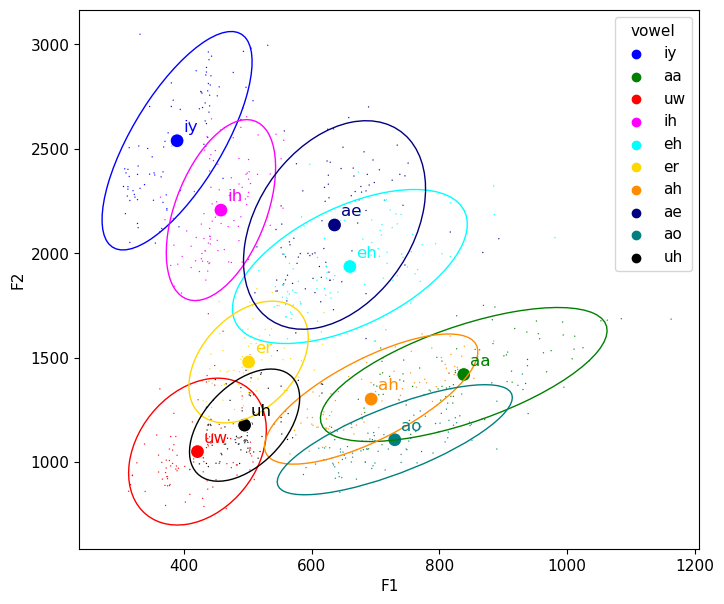

In [27]:
vowels = vow10
fig,ax=plt.subplots()
sns.scatterplot(ax=ax,x='F1',y='F2',data=data10,hue="vowel",s=1,hue_order=vowels,legend=False)
sns.scatterplot(ax=ax,data=formants_all,x='F1',y='F2',hue='vowel',hue_order=vowels,s=100)
for vow in vowels:
    F1 = formants_all['F1'][vow]
    F2 = formants_all['F2'][vow]
    ax.text(F1+10,F2+30,vow,ha='left',va='bottom',fontsize=12,color=vowel2color[vow] )    

    vowdata = select_hillenbrand(hildata,genders=genders,vowels=[vow])
    Spch.plot_confidence_ellipse(vowdata['F1'], vowdata['F2'], ax, n_std=n_std, edgecolor=vowel2color[vow] )

## 5. Formant Triangle
Thte "Formant Triangle" refers to the fact that the average positions of all vowels in the F1-F2 plane
are roughly situated on a triangle with as edge points iy, aa and uw.   
Remark also that there is one vowel ('er') that doesn't fit the above at all as it is situated in the center of the triangle.


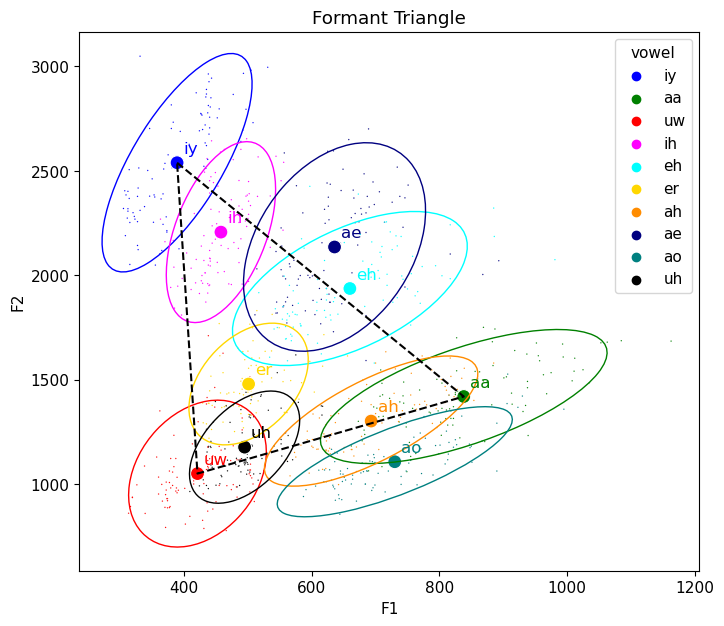

In [28]:
f1_vals = [ formants_all['F1'][v] for v in ['iy','aa','uw'] ]
f2_vals = [ formants_all['F2'][v] for v in ['iy','aa','uw'] ]
ax.plot([f1_vals[k] for k in [0,1,2,0]],[f2_vals[k] for k in [0,1,2,0]],color='k',linestyle='dashed')
ax.set_title('Formant Triangle')
fig

## Gender Dependency of formants

The formant confidence ellipses look quite different when we separate the data per gender.
Confusion is obviously much less if the gender would have been known a priori or if it can be inferred from other speech characteristics.

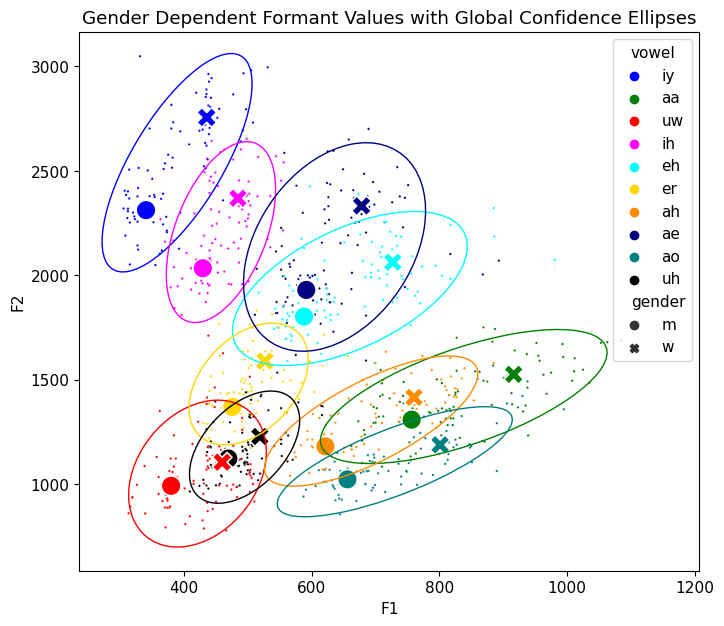

In [33]:
vowels = vow10
#data = formants
fig,ax =plt.subplots()
sns.scatterplot(ax=ax,x='F1',y='F2',data=data10,hue="vowel",s=5,hue_order=vowels,legend=False)
sns.scatterplot(ax=ax,data=formants,x='F1',y='F2',hue='vowel',hue_order=vowels,style='gender',s=200)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for vow in vowels:
    vowdata = select_hillenbrand(hildata,genders=['m','w'],vowels=[vow])
    Spch.plot_confidence_ellipse(vowdata['F1'], vowdata['F2'], fig.axes[0], n_std=2, edgecolor=vowel2color[vow])
ax.set_title("Gender Dependent Formant Values with Global Confidence Ellipses");

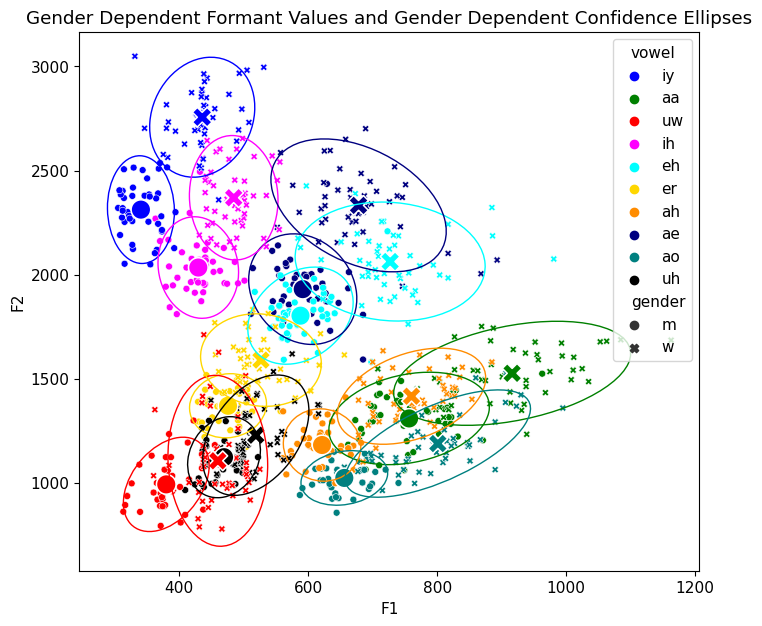

In [48]:
# only for male or female data
vowels = vow10
genders = ['m','w']
gmarkers = ['o','X']
fig,ax=plt.subplots()
for i in [0,1]:
    sns.scatterplot(ax=ax,x='F1',y='F2',data=data10.loc[data10['gender']==genders[i]],marker = gmarkers[i],hue="vowel",s=25,hue_order=vowels,legend=False)
sns.scatterplot(ax=ax,data=formants,x='F1',y='F2',hue='vowel',hue_order=vowels,style='gender',s=200)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for gender in genders:
    for vow in vowels:
        vowdata = select_hillenbrand(hildata,vowels=[vow],genders=[gender])
        Spch.plot_confidence_ellipse(vowdata['F1'], vowdata['F2'], ax, n_std=2, edgecolor=vowel2color[vow])
ax.set_title("Gender Dependent Formant Values and Gender Dependent Confidence Ellipses");

##  6. Grid plots for higher dimensional data

In most of the scatter plots we limited ourselves to the F1-F2 data.   However, while F1-F2 may be some of the most relevant features of speech, there is much more: F3, f0, ....

The 2D scatter plot has its limits if we want to see how all these features can work together.  A simple extension of the scatter plot is the grid plot which combines a multitude of 2D scatter plots.  It doesn't show the true high-dimensional distribution but a number of 2D sub views which already can tell quite a bit more.

It is quite obvious that extra information may be obtained from F3 and f0.
- f0 has a rather clean bimodal distribution, which correlates well to gender
- F3 is in a few cases very complementary, e.g. for /er/, which is not well distinguished with F1,F2 alone

<Figure size 1000x1000 with 0 Axes>

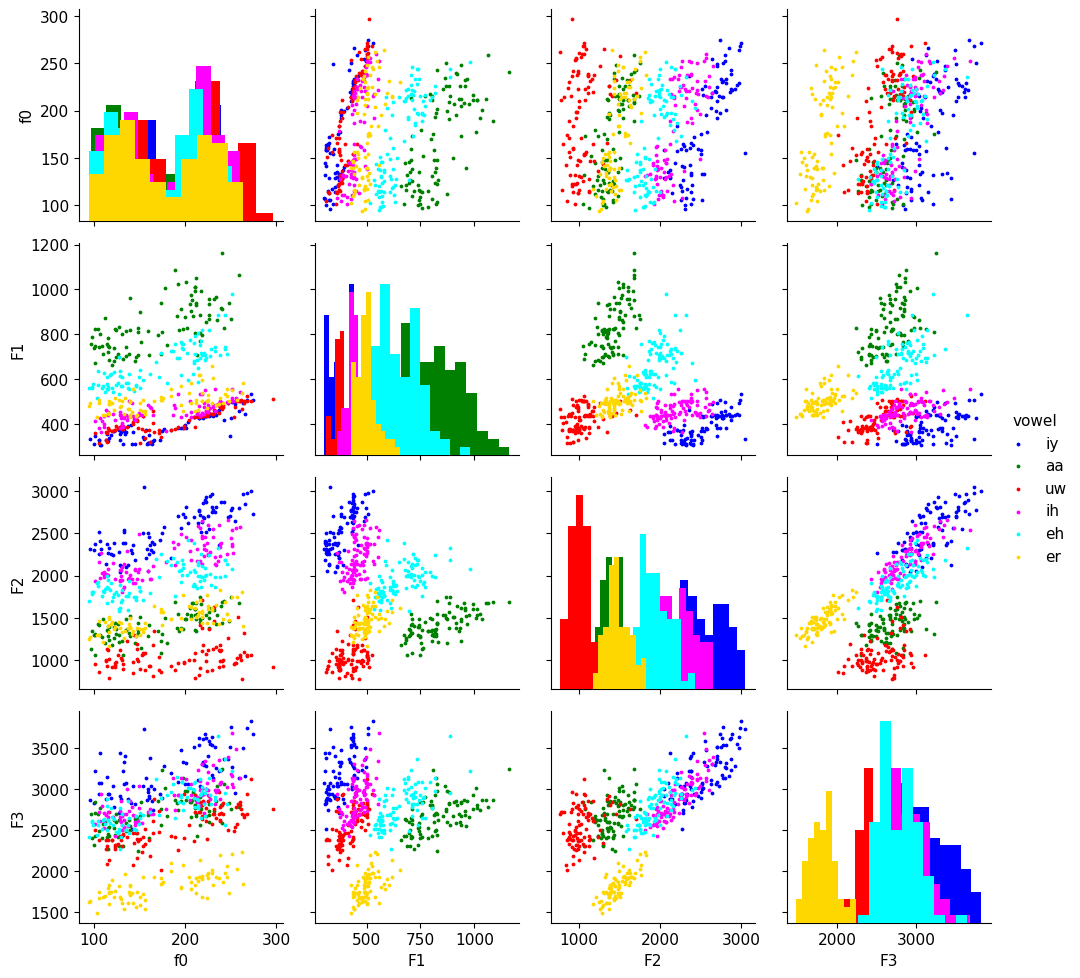

In [32]:
genders = ['m','w']
nvow = 6
features = ['f0','F1','F2','F3']
# select data and set classes / side_kick
data =select_hillenbrand(hildata,genders=genders,vowels=vow6)
target = 'vowel'
classes = vow6
side_classes = genders


##########################
# 1. make a grid plot using all features and the target as hue 
fig=plt.figure(figsize=(10,10))
g = sns.PairGrid(data.loc[:,[target]+features],hue=target,hue_order=classes)
g.map_diag(plt.hist, linewidth=1)
g.map_offdiag(plt.scatter,s=3)
g.add_legend()
fig.suptitle("Multi-feature Scatter Plots (features: " + " ".join(features) +")" );
#

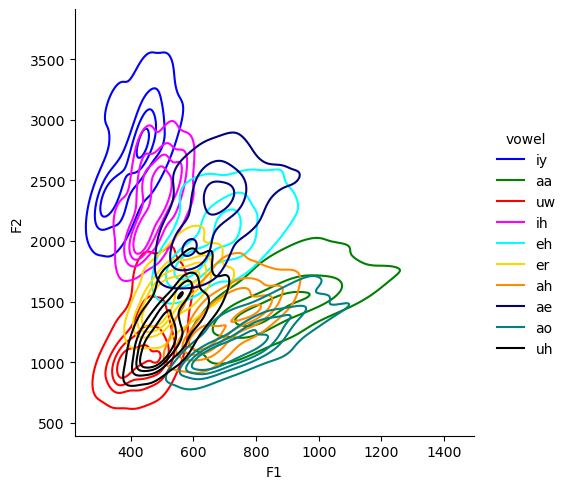

In [16]:
# showing with kernel density plots
data = select_hillenbrand(hildata,vowels=vow10)
sns.displot(data, x="F1", y="F2", hue="vowel", kind="kde",hue_order=vow10,levels=5,bw_adjust=1)
#plt.yscale('log')
#plt.ylim([700.,3200.])
#plt.xlim([250.,1200.])